In [1]:
import pandas as pd

# tweaking settings to see all columns on screen
pd.set_option('display.max_columns', None)

import numpy as np
import time
import math
from datetime import timedelta 
from datetime import datetime

N = 3 # number of lanes
FT_MI = 5280 # mile to feet conversion
TAO = 1.75 #
SPEED_CONVER = 5280/3600 # ft/s to mph conversion
L = 14.75 # typical length of a car
l = 5 # loop length
DEPARTURE_CONVER = 120 # hourly departure of v vehicles; raw data shows vehicles per 30 seconds

q_ramps = [1008,971,934,896,859,822,785,748,710,673,636,599,562,524,484]   # hypothetical q_ramp
q_ramps = [i* 2 for i in q_ramps]   # two ramps => double the discharge

## Data Cleaning

In [2]:
# read csv
df = pd.read_csv('78 EB.csv')

# select ['Name']s with word 'to'
df = df[df.Name.str.contains('to')] # those that dont have 'to' is radar data; no ramp data
df['Name'] = df['Name'].apply(lambda x: x.split('to')[0][:-1])

date = df['Date'].tolist()[0]

# drop unnecessary columns
df = df[['Name', 'Time', 'Id', 'pcw1speed', 'pcw1vol', 'r_1_offcnt', 'r_2_offcnt', 'MlDetPostmile', 'pcw1occ']]

# rename columns
df.rename(columns={"pcw1speed": "V_ups",
                   "pcw1vol": "Q_ups",
                   "MlDetPostmile": "postmile",
                   "pcw1occ": "occupancy"}, inplace = True)

                   
# per_occ = density * (L+(lengthofloop=10))/(5280+density*l) # percent occupancy

# convert Nan values to 0
df['r_2_offcnt'] = df['r_2_offcnt'].fillna(0) # some have Nan values because there 

# change all V_ups value of 0 to the previous data
df['V_ups'] = df['V_ups'].replace(to_replace=0, method='ffill')

# convert datatype of 'time' to datetime 
def convtime(s):
    return datetime.strptime(s, '%H:%M:%S').time()

df['convtime'] = df['Time'].apply(convtime)

# Calculation

### Using arbitrary values of q_ramps

In [3]:
# calculate q_exit
df['q_exit'] = (df['r_1_offcnt'] + df['r_2_offcnt']) * DEPARTURE_CONVER
df.drop(['r_1_offcnt', 'r_2_offcnt'], axis=1, inplace = True)

# shift q_exit values to account the fact that we need to use q_exit values from the next station

times = df['convtime'].unique()
correct_q_exit = pd.DataFrame()

for time in times:
    temp_df = df.loc[df['convtime'] == time]
    temp_df = temp_df.sort_values(by=['postmile'], ascending=True)
    temp_df['q_exit'] = temp_df['q_exit'].shift(-1)
    temp_df.drop(temp_df.tail(1).index,inplace=True)
    correct_q_exit = pd.concat([correct_q_exit, temp_df], axis=0, sort=True)
    
df = correct_q_exit


# shift q_exit values to account the fact that we need to use q_exit values from one minute later
unique_ids = df['Id'].unique()
correct_q_exit = pd.DataFrame()

for unique_id in unique_ids:
    temp_df = df.loc[df['Id'] == unique_id]
    temp_df = temp_df.sort_values(by=['convtime'], ascending=True)
    temp_df['q_exit'] = temp_df['q_exit'].shift(-1)
    temp_df.drop(temp_df.tail(1).index,inplace=True)
    correct_q_exit = pd.concat([correct_q_exit, temp_df], axis=0, sort=True)
    
df = correct_q_exit

In [4]:
# change all q_exit value of Nan to the previous data
df = df.fillna(method='ffill')

# change all Nan values to preceeding value
df = df.fillna(method='ffill')

In [5]:
# the larger the weight, the more efficient the n_ds
def weight(n_ds, Q_ups, V_ups):
    n_ups = Q_ups/V_ups
    n_goal = 1.15 * n_ups
    temp = n_ds-n_goal
    R = 10 # arbitrary variable for normal Gaussian distribution 
    return (1/((2*math.pi*R)**(1/2))) * math.e**((-1)*((n_ds-n_goal)**2)/(2*R))

In [6]:
Q_ups = df['Q_ups']
V_ups = df['V_ups']
q_exit = df['q_exit']

# calculate n_merge and V_merge
for q_ramp in q_ramps:
    n_merge = q_ramp/V_ups
    df['n_merge_' + str(q_ramp)] = n_merge
    df['V_merge_' + str(q_ramp)] = (FT_MI-n_merge*L) / (n_merge*TAO*SPEED_CONVER)
    
# split df by "Id" to shift values; we use some values that are recorded by sensors a minute ago and some current 
new_df = pd.DataFrame(columns = df.columns)
unique_ids = df['Id'].unique().tolist()    

for unique_id in unique_ids:
    temp_df = df.loc[df['Id'] == unique_id]
    
    # shift down values for calculation
    temp_df = temp_df.sort_values(by=['convtime'], ascending=True)
    temp_df['V_ups'] = temp_df['V_ups'].shift(1)
    temp_df['Q_ups'] = temp_df['Q_ups'].shift(1)
    temp_df.drop(temp_df.head(1).index,inplace=True)
    
    new_df = pd.concat([new_df, temp_df], axis=0, sort=True)
    
V_merge = new_df['V_merge_' + str(q_ramp)]
V_ups = new_df['V_ups']
Q_ups = new_df['Q_ups']
q_exit = new_df['q_exit']
    
# calculate n_ds
for q_ramp in q_ramps:
    new_df['n_ds_' + str(q_ramp)] = (1/V_ups) * (Q_ups + (q_ramp/N)) - ((1/N) * (q_exit/V_merge))

for q_ramp in q_ramps:
    R = 10 # arbitrary variable for normal Gaussian distribution 
    n_ds = new_df['n_ds_' + str(q_ramp)]
    new_df['weight_' + str(q_ramp)] = weight(n_ds, Q_ups, V_ups)

In [7]:
cols=[]

for q_ramp in q_ramps:
    cols.append('weight_' + str(q_ramp))

# choose the largest value across multiple columns
new_df = new_df.assign(q_ramp=new_df[cols].idxmax(axis=1))
new_df['q_ramp'] = new_df['q_ramp'].apply(lambda x: str(x).split('_')[1])
new_df = new_df[['Id', 'Name', 'Q_ups', 'Time', 'V_ups', 'convtime', 'occupancy', 'postmile', 'q_exit', 'q_ramp']]

### Using Gaussian Distribution

In [8]:
# mu: mean; best_rate
# sigma: standard deviation
def generate_range(mu, sigma=2):
    return np.random.normal(mu, sigma, 15).tolist()

In [9]:
matrix = pd.DataFrame(columns = new_df.columns)
best_q_ramps = new_df['q_ramp'].unique().tolist()

for best_q_ramp in best_q_ramps:
    temp_df = new_df.loc[new_df['q_ramp'] == best_q_ramp]
    q_ramps = generate_range(float(best_q_ramp))
    V_ups = temp_df['V_ups']
    Q_ups = temp_df['Q_ups']
    q_exit = temp_df['q_exit']
    
    for q_ramp in q_ramps:
        temp_df['n_merge_' + str(q_ramp)] = q_ramp/V_ups

    for q_ramp in q_ramps:
        n_merge = temp_df['n_merge_' + str(q_ramp)]
        temp_df['V_merge_' + str(q_ramp)] = (FT_MI-n_merge*L) / (n_merge*TAO*SPEED_CONVER)

    V_merge = temp_df['V_merge_' + str(q_ramp)]
    V_ups = temp_df['V_ups']
    Q_ups = temp_df['Q_ups']
    q_exit = temp_df['q_exit']
    
    for q_ramp in q_ramps:
        temp_df['n_ds_' + str(q_ramp)] = (1/V_ups) * (Q_ups + (q_ramp/N)) - ((1/N) * (q_exit/V_merge))
        
    for q_ramp in q_ramps:
        n_ds = temp_df['n_ds_' + str(q_ramp)]
        temp_df['weight_' + str(q_ramp)] = weight(n_ds, Q_ups, V_ups)
        
    cols=[]

    for q_ramp in q_ramps:
        cols.append('weight_' + str(q_ramp))

    # choose the largest value across multiple columns
    temp_df = temp_df.assign(q_ramp=temp_df[cols].idxmax(axis=1))
    temp_df['q_ramp'] = temp_df['q_ramp'].apply(lambda x: float(str(x).split('_')[1]))
    
    temp_df.reset_index(inplace=True)
    q_ramp = temp_df['q_ramp'].tolist()
    temp_df['n_ds'] = 0

    for i, each in enumerate(q_ramp):
        temp_df.loc[i, 'n_ds_' + str(each)]
        temp_df.loc[i, 'n_ds'] = temp_df.loc[i, 'n_ds_' + str(each)]
    temp_df = temp_df[['Id', 'Name', 'Q_ups', 'Time', 'V_ups', 'convtime', 'occupancy', 'postmile', 'q_exit', 'q_ramp', 'n_ds']]
    
    matrix = pd.concat([matrix, temp_df], axis=0, sort=True)

/Users/taekunkim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/taekunkim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Users/taekunkim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

# Visualization

In [10]:
# libraries
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [11]:
time = "17:30:00"

toPlot = matrix.loc[matrix['Time'] == time]

# calculate distance between each ramp
toPlot = toPlot.sort_values('postmile')
toPlot['distance'] = toPlot[['postmile']].diff(periods=1)['postmile']
df[-1, 'distance'] = 0.0

# calculate travel time
toPlot['travel_time'] = toPlot['V_ups'] * toPlot['distance']

# calculate volume
toPlot['volume'] = toPlot['V_ups'] * toPlot['n_ds']

# calculate occupancy
toPlot['occupancy'] = (toPlot['n_ds']*(L+l))/(5280+(toPlot['n_ds']+l))

# drop unnecessary columns
toPlot = toPlot.drop(columns = ['Id', 'Q_ups', 'convtime', 'Time', 'q_exit', 'q_ramp', 'n_ds', 'postmile'])

# rename columns
toPlot.rename(columns={"V_ups": "Speed(mph)", 
                       "distance": "Distance(mi)", 
                       "occupancy": "Occupancy(%)",
                       "volume": "Volume",
                       "travel_time": "Travel Time(min)"}, inplace=True)

original_toPlot = toPlot.copy()

In [12]:
toPlot

,Name,Speed(mph),Occupancy(%),Distance(mi),Travel Time(min),Volume
33,Jefferson St,68.0,0.088833,NaN,NaN,1623.747766
1423,El Camino Real,35.0,0.187521,0.736,25.760,1773.119224
53,Plaza Dr,55.0,0.099806,1.992,109.560,1476.384975
2917,Emerald Dr,60.0,0.102451,0.888,53.280,1653.494501
3706,Vista Village Dr,72.0,0.082744,1.846,132.912,1600.914987
4529,Escondido Ave,71.0,0.078797,0.566,40.186,1503.079150
106,Mar Vista Dr,70.0,0.098371,0.910,63.700,1851.868446
6076,Sycamore Ave,70.0,0.071863,1.422,99.540,1351.023779
28,Rho Santa Fe Rd,31.0,0.203286,1.462,45.322,1703.883190
7664,Las Posas Rd/Grand Ave,27.0,0.252090,0.684,18.468,1844.914987


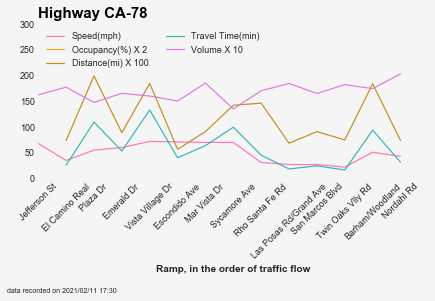

<Figure size 432x288 with 0 Axes>

In [13]:
labels = [
          'Speed(mph)',
          'Occupancy(%) X 2',
          'Distance(mi) X 100',
          'Travel Time(min)',
          'Volume X 10'
          ]
toPlot['Occupancy(%)'] = toPlot['Occupancy(%)']*200
toPlot['Occupancy(%)'] = toPlot['Occupancy(%)']*200
toPlot['Distance(mi)'] = toPlot['Distance(mi)']*100
toPlot['Volume'] = toPlot['Volume']*1/10

toPlot.reset_index(inplace=True)


  
# Change the style of plot
plt.style.use('seaborn-dark')


# Set the background colors
fig = plt.figure()
fig.patch.set_facecolor('whitesmoke')

ax = fig.add_subplot(111)
ax.set_facecolor("whitesmoke")

# Initialize x_labels
x_label = toPlot.pop('Name')

# Initialize colors
colors = plotcolor = ['hotpink','orange','darkgoldenrod','lightseagreen','orchid']
 
# Add titles
plt.title("Highway CA-78", loc='left', fontsize=15, fontweight='bold', color='black')
plt.xlabel("Ramp, in the order of traffic flow", fontsize=10, fontweight='bold')
plt.xticks(rotation = 45)
# # Show the graph

num=0
for column, name, color in zip(toPlot.columns[1:], labels, colors): # start from 1 to avoid index from being plotted
    num+=1
    plt.plot(x_label, toPlot[column], marker='', color=color, linewidth=1.2, alpha=0.9, label=name)
    
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(9)

plt.axis([0, len(x_label), 0, 300])
plt.legend(loc=2, ncol=2, prop={'size': 9})

annotation = "data recorded on " + date + " " + time[:-3]
plt.figtext(0, -0.03, annotation, fontsize=7)


plt.tight_layout()
fig1 = plt.gcf()
plt.show()
plt.draw()
plt.gcf().subplots_adjust(bottom=0.45)
fig1.savefig('graph.png', dpi=500)

toPlot = original_toPlot

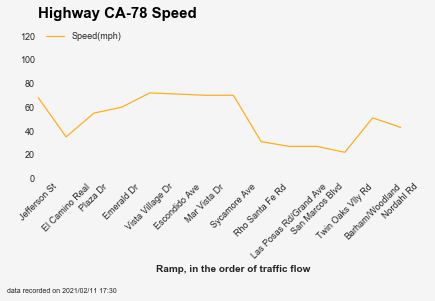

<Figure size 432x288 with 0 Axes>

In [14]:
# plot speed

# Change the style of plot
plt.style.use('seaborn-dark')

# Set the background colors
fig = plt.figure()
fig.patch.set_facecolor('whitesmoke')

ax = fig.add_subplot(111)
ax.set_facecolor("whitesmoke")

# Initialize colors
colors = plotcolor = ['hotpink','orange','darkgoldenrod','lightseagreen','orchid']

# Initialize x_labels
# defined in previous block

# Add titles
plt.title("Highway CA-78 Speed", loc='left', fontsize=15, fontweight='bold', color='black')
plt.xlabel("Ramp, in the order of traffic flow", fontsize=10, fontweight='bold')
plt.xticks(rotation = 45)

# plot graph
plt.plot(x_label, toPlot['Speed(mph)'], marker='', color='orange', linewidth=1.2, alpha=0.9, label='Speed(mph)')
    
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(9)

plt.axis([0, len(x_label), 0, 130])
plt.legend(loc=2, ncol=2, prop={'size': 9})

annotation = "data recorded on " + date + " " + time[:-3]
plt.figtext(0, -0.03, annotation, fontsize=7)


plt.tight_layout()
fig1 = plt.gcf()
plt.show()
plt.draw()
plt.gcf().subplots_adjust(bottom=0.45)
fig1.savefig('speed.png', dpi=500)

toPlot = original_toPlot

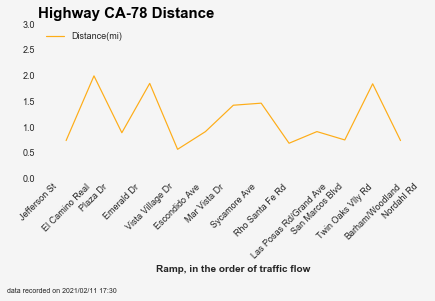

<Figure size 432x288 with 0 Axes>

In [15]:
# plot distance

# Change the style of plot
plt.style.use('seaborn-dark')

# Set the background colors
fig = plt.figure()
fig.patch.set_facecolor('whitesmoke')

ax = fig.add_subplot(111)
ax.set_facecolor("whitesmoke")

# Initialize colors
colors = plotcolor = ['hotpink','orange','darkgoldenrod','lightseagreen','orchid']

# Initialize x_labels
# x_label = toPlot.pop('Name')

# Add titles
plt.title("Highway CA-78 Distance", loc='left', fontsize=15, fontweight='bold', color='black')
plt.xlabel("Ramp, in the order of traffic flow", fontsize=10, fontweight='bold')
plt.xticks(rotation = 45)

# plot graph
plt.plot(x_label, toPlot['Distance(mi)'], marker='', color='orange', linewidth=1.2, alpha=0.9, label='Distance(mi)')
    
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(9)

plt.axis([0, len(x_label), 0, 3])
plt.legend(loc=2, ncol=2, prop={'size': 9})

annotation = "data recorded on " + date + " " + time[:-3]
plt.figtext(0, -0.03, annotation, fontsize=7)


plt.tight_layout()
fig1 = plt.gcf()
plt.show()
plt.draw()
plt.gcf().subplots_adjust(bottom=0.45)
fig1.savefig('distance.png', dpi=500)

toPlot = original_toPlot

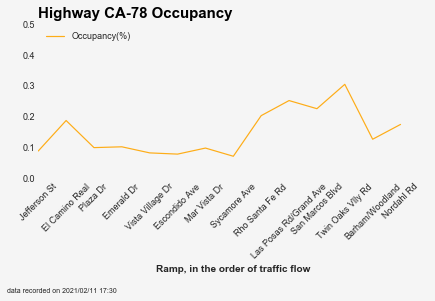

<Figure size 432x288 with 0 Axes>

In [16]:
# plot distance

# Change the style of plot
plt.style.use('seaborn-dark')

# Set the background colors
fig = plt.figure()
fig.patch.set_facecolor('whitesmoke')

ax = fig.add_subplot(111)
ax.set_facecolor("whitesmoke")

# Initialize colors
colors = plotcolor = ['hotpink','orange','darkgoldenrod','lightseagreen','orchid']

# Initialize x_labels
# x_label = toPlot.pop('Name')

# Add titles
plt.title("Highway CA-78 Occupancy", loc='left', fontsize=15, fontweight='bold', color='black')
plt.xlabel("Ramp, in the order of traffic flow", fontsize=10, fontweight='bold')
plt.xticks(rotation = 45)

# plot graph
plt.plot(x_label, toPlot['Occupancy(%)'], marker='', color='orange', linewidth=1.2, alpha=0.9, label='Occupancy(%)')
    
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(9)

plt.axis([0, len(x_label), 0, 0.5])
plt.legend(loc=2, ncol=2, prop={'size': 9})

annotation = "data recorded on " + date + " " + time[:-3]
plt.figtext(0, -0.03, annotation, fontsize=7)


plt.tight_layout()
fig1 = plt.gcf()
plt.show()
plt.draw()
plt.gcf().subplots_adjust(bottom=0.45)
fig1.savefig('occupancy.png', dpi=500)

toPlot = original_toPlot

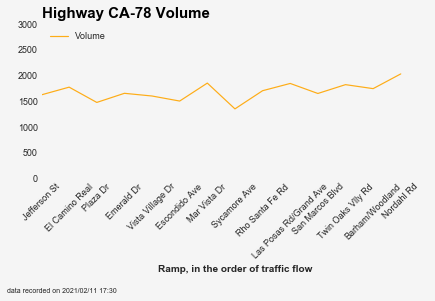

<Figure size 432x288 with 0 Axes>

In [17]:
# plot distance

# Change the style of plot
plt.style.use('seaborn-dark')

# Set the background colors
fig = plt.figure()
fig.patch.set_facecolor('whitesmoke')

ax = fig.add_subplot(111)
ax.set_facecolor("whitesmoke")

# Initialize colors
colors = plotcolor = ['hotpink','orange','darkgoldenrod','lightseagreen','orchid']

# Initialize x_labels
# x_label = toPlot.pop('Name')

# Add titles
plt.title("Highway CA-78 Volume", loc='left', fontsize=15, fontweight='bold', color='black')
plt.xlabel("Ramp, in the order of traffic flow", fontsize=10, fontweight='bold')
plt.xticks(rotation = 45)

# plot graph
plt.plot(x_label, toPlot['Volume'], marker='', color='orange', linewidth=1.2, alpha=0.9, label='Volume')
    
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(9)

plt.axis([0, len(x_label), 0, 3000])
plt.legend(loc=2, ncol=2, prop={'size': 9})

annotation = "data recorded on " + date + " " + time[:-3]
plt.figtext(0, -0.03, annotation, fontsize=7)


plt.tight_layout()
fig1 = plt.gcf()
plt.show()
plt.draw()
plt.gcf().subplots_adjust(bottom=0.45)
fig1.savefig('volume.png', dpi=500)

toPlot = original_toPlot

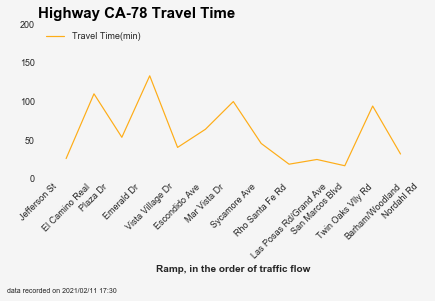

<Figure size 432x288 with 0 Axes>

In [18]:
# plot distance

# Change the style of plot
plt.style.use('seaborn-dark')

# Set the background colors
fig = plt.figure()
fig.patch.set_facecolor('whitesmoke')

ax = fig.add_subplot(111)
ax.set_facecolor("whitesmoke")

# Initialize colors
colors = plotcolor = ['hotpink','orange','darkgoldenrod','lightseagreen','orchid']

# Initialize x_labels
# x_label = toPlot.pop('Name')

# Add titles
plt.title("Highway CA-78 Travel Time", loc='left', fontsize=15, fontweight='bold', color='black')
plt.xlabel("Ramp, in the order of traffic flow", fontsize=10, fontweight='bold')
plt.xticks(rotation = 45)

# plot graph
plt.plot(x_label, toPlot['Travel Time(min)'], marker='', color='orange', linewidth=1.2, alpha=0.9, label='Travel Time(min)')
    
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(9)

plt.axis([0, len(x_label), 0, 200])
plt.legend(loc=2, ncol=2, prop={'size': 9})

annotation = "data recorded on " + date + " " + time[:-3]
plt.figtext(0, -0.03, annotation, fontsize=7)


plt.tight_layout()
fig1 = plt.gcf()
plt.show()
plt.draw()
plt.gcf().subplots_adjust(bottom=0.45)
fig1.savefig('travel_time.png', dpi=500)

toPlot = original_toPlot

In [19]:
toPlot

,Name,Speed(mph),Occupancy(%),Distance(mi),Travel Time(min),Volume
33,Jefferson St,68.0,0.088833,NaN,NaN,1623.747766
1423,El Camino Real,35.0,0.187521,0.736,25.760,1773.119224
53,Plaza Dr,55.0,0.099806,1.992,109.560,1476.384975
2917,Emerald Dr,60.0,0.102451,0.888,53.280,1653.494501
3706,Vista Village Dr,72.0,0.082744,1.846,132.912,1600.914987
4529,Escondido Ave,71.0,0.078797,0.566,40.186,1503.079150
106,Mar Vista Dr,70.0,0.098371,0.910,63.700,1851.868446
6076,Sycamore Ave,70.0,0.071863,1.422,99.540,1351.023779
28,Rho Santa Fe Rd,31.0,0.203286,1.462,45.322,1703.883190
7664,Las Posas Rd/Grand Ave,27.0,0.252090,0.684,18.468,1844.914987


In [20]:
# # Dataframe
# toPlot = matrix.loc[matrix['Id'] == 201]
# toPlot = toPlot[['V_ups', 'Time']]
# toPlot['Time'] = pd.to_datetime(toPlot.Time)
# toPlot = toPlot.groupby(pd.Grouper(key='Time', freq='30min')).mean().dropna()
  
# # Change the style of plot
# plt.style.use('seaborn-darkgrid')
 
# # Create a color palette
# palette = plt.get_cmap('Set1')
 
# # Plot multiple lines
# num=0
# for column in toPlot.columns:
#     num+=1
#     plt.plot(toPlot.index.hour, toPlot[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label=column)

# # Add legend
# plt.legend(loc=2, ncol=2)
 
# # Add titles
# plt.title("Speed VS Time", loc='left', fontsize=12, fontweight=0, color='orange')
# plt.xlabel("Hour")
# plt.xticks(rotation = 45)
# plt.ylabel("Speed (mph)")
# plt.ylim(0, 80)

# # Show the graph
# plt.show()

# Tensorflow
#### Build a DL model that can

In [21]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.preprocessing import image
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

learning_rate = 0.01

In [22]:
# Clean Data

# shift values V_ups and Q_ups to dertive values V_ds and Q_ds

times = matrix['convtime'].unique()
correct_df = pd.DataFrame()
for time in times:
    temp_df = matrix.loc[matrix['convtime'] == time]
    temp_df = temp_df.sort_values(by=['postmile'], ascending=True)
    temp_df['Q_ds'] = temp_df['Q_ups'].shift(-1)
    temp_df['V_ds'] = temp_df['V_ups'].shift(-1)
    temp_df.drop(temp_df.tail(1).index,inplace=True)
    correct_df = pd.concat([correct_df, temp_df], axis=0, sort=True)
    
matrix = correct_df
    
unique_ids = matrix['Id'].unique()
correct_df = pd.DataFrame()
for unique_id in unique_ids:
    temp_df = matrix.loc[matrix['Id'] == unique_id]
    temp_df['Q_ds'] = temp_df['Q_ds'].shift(-1)
    temp_df['V_ds'] = temp_df['V_ds'].shift(-1)
    temp_df.drop(temp_df.tail(1).index,inplace=True)
    correct_df = pd.concat([correct_df, temp_df], axis=0, sort=True)
    
input_df = correct_df
input_df['num_lanes'] = np.full(input_df.shape[0], N)

/Users/taekunkim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/taekunkim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/taekunkim/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

In [23]:
# split training set
X = input_df[['Q_ups', 'V_ups', 'q_ramp', 'num_lanes']]
y = input_df[['Q_ds', 'V_ds']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [24]:
# Fit model

def get_compiled_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    
    tf.keras.optimizers.Adam(
        learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
        name='Adam'
    )
    
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy']
                 )
    
    return model

model = get_compiled_model()
model.fit(X_train, y_train, epochs=15)

Epoch 1/15
273/273 [==============================] - 1s 1ms/step - loss: -1865905.5589 - accuracy: 0.7510
Epoch 2/15
273/273 [==============================] - 0s 2ms/step - loss: -59684721.8686 - accuracy: 0.9543
Epoch 3/15
273/273 [==============================] - 0s 1ms/step - loss: -346473629.3139 - accuracy: 0.9512
Epoch 4/15
273/273 [==============================] - 0s 2ms/step - loss: -1039008708.9051 - accuracy: 0.9516
Epoch 5/15
273/273 [==============================] - 0s 1ms/step - loss: -2230924250.6277 - accuracy: 0.9518
Epoch 6/15
273/273 [==============================] - 0s 1ms/step - loss: -4027977756.0292 - accuracy: 0.9530
Epoch 7/15
273/273 [==============================] - 0s 2ms/step - loss: -6489332717.3139 - accuracy: 0.9510
Epoch 8/15
273/273 [==============================] - 0s 1ms/step - loss: -9607023034.8613 - accuracy: 0.9521
Epoch 9/15
273/273 [==============================] - 0s 1ms/step - loss: -13573741302.6569 - accuracy: 0.9543
Epoch 10/15
273

In [25]:
# Evaluate Model
model.evaluate(X_test, y_test)

69/69 [==============================] - 0s 675us/step - loss: -62369849344.0000 - accuracy: 0.9518


[-62369849344.0, 0.9517906308174133]

# UNEXPECTED VALUE RETURNED FROM MODEL:

In [38]:
print('Expected:')
print(y_test)
print('What the model returns:')
print(model.predict(X_test))

arr = model.predict(X_test)
fake = pd.DataFrame(arr)
fake.iloc[:, 1].unique()

Expected:
        Q_ds  V_ds
3410  1005.0  61.0
1581   487.0  64.0
106    761.0  70.0
3508  1340.0  72.0
6022  1188.0  20.0
...      ...   ...
158    761.0  58.0
6421   914.0  87.0
4071  1066.0  12.0
1413  1584.0  59.0
7505  1523.0  26.0

[2178 rows x 2 columns]
What the model returns:
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


array([0.])

In [27]:
simple_test = df.iloc[1, :9].to_frame().transpose().reset_index()
simple_test

,index,Id,Name,Q_ups,Time,V_ups,convtime,occupancy,postmile,q_exit
0,21,201,Jefferson St,182,05:31:00,75,05:31:00,1.1,0.858,120


In [28]:
test_df = pd.DataFrame()

q_ramps = [1008,971,934,896,859,822,785,748,710,673,636,599,562,524,484]   # hypothetical q_ramp
Q_ups = simple_test.loc[0, 'Q_ups']
V_ups = simple_test.loc[0, 'V_ups']
q_exit = simple_test.loc[0, 'q_exit']

test_df['q_ramp'] = q_ramps
test_df['Q_ups'] = Q_ups
test_df['V_ups'] = V_ups
test_df['q_exit'] = q_exit

test_df

,q_ramp,Q_ups,V_ups,q_exit
0,1008,182,75,120.0
1,971,182,75,120.0
2,934,182,75,120.0
3,896,182,75,120.0
4,859,182,75,120.0
5,822,182,75,120.0
6,785,182,75,120.0
7,748,182,75,120.0
8,710,182,75,120.0
9,673,182,75,120.0


### Our model accurately calculates Q_ds and V_ds. 
### We are now ready to compare our particle filter model with the DL model.